### Loading Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import normalize
from keras import backend



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import glob 
import math 
import shutil
import os
import time
plt.rcParams['figure.figsize'] = [15, 5]
base_log_dir = "./logs/"
sns.set_style("darkgrid")

if not os.path.exists(base_log_dir):
    os.makedirs(base_log_dir)

### Plotting utils

In [3]:
def CalculateMetricsAndPlot(true_label, predicted_label,color="Blues",text="",is_show=True):
    if is_show:
        plt.rcParams['figure.figsize'] = [9, 6]
    CM = confusion_matrix(true_label, predicted_label)
    acc = round(accuracy_score(true_label,predicted_label)*100,2)
    precision = round(precision_score(true_label,predicted_label, average='macro'),2)
    if text == "":
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for Test Data | Accuracy={0}% | Precision={1}".format(acc,precision))
    else :
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for Test Data | Accuracy={0}% | Precision={1} | {2}".format(acc,precision,text))
    if is_show:
        plt.show()

def TrainingPlot(_history,text=None,is_show=True):
    if is_show :
        plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(1,2,1)
    plt.plot(_history["loss"],label="Train loss")
    plt.plot(_history["val_loss"],label="Validation loss")
    if not text is None:
        plt.title("Loss/Epoch | {0}".format(text))
    else:
        plt.title("Loss/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Sparse Categorical Crossentropy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(_history["accuracy"],label="Train accuracy")
    plt.plot(_history["val_accuracy"],label="Validation accuracy")
    if not text is None:
        plt.title("Accuracy/Epoch | {0}".format(text))
    else:
        plt.title("Accuracy/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy in %")
    plt.legend()
  
    plt.tight_layout()
    if is_show:
        plt.show()
        
    plt.show()


### Loading Dataset & Pre

In [4]:
def LabelProcess(label):
    if label in ['normal', "ok"]:
        return 1 
    return 0 

def GetDataset(path="./"):
    data = ""
    for i in range(1,6):        
        d = open(path+"lp{0}.data".format(i),"r").read()
        d = "\n" + d 
        data += d + "\n"
    
    data = list(data.split("\n\n"))
    Y = []
    _y = []
    X = np.zeros(shape=(len(data)-2,15,6))
    
    for index in range(len(data)-2):
        lines = list(data[index].split("\n"))
        
        _y.append(lines[1])
        Y.append(LabelProcess(lines[1]))
        
        tmp = np.zeros(shape=(15,6))
        lines = lines[2:]
        for i in range(15):
            line = lines[i]
            elements = list(line.split("\t"))
            for j in range(6):
                tmp[i,j] = int(elements[j+1])
        X[index,:,:] = tmp
        
    return X,np.array(Y)
   
        
X_total,Y_total = GetDataset()   
tmp = normalize(np.reshape(X_total,newshape=(X_total.shape[0],15*6)))
X_total = np.reshape(X_total,newshape=(tmp.shape[0],15,6))

X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2,stratify=Y_total)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.125,stratify=Y_train)

### Jordan Cell

In [5]:
class JordanCell(keras.layers.SimpleRNNCell):
    def __init__(self,n=2,**kwargs):
        super(JordanCell, self).__init__(**kwargs)   
        self.softmax_layer = tf.keras.layers.Dense(n, activation='softmax')
        self.n = n

    def call(self, inputs, states, training=None):
        output,new_state = super().call(
            inputs=inputs, states = states, training=training
        )
        new_state = output
        zeros = tf.zeros_like(new_state)
        predict = self.softmax_layer(new_state)
        _merge = Concatenate()([zeros[:,:new_state.shape[1]-self.n],predict])
        return predict,[_merge]

### Ensemble both Elman & Jordan networks

In [6]:
keras.backend.clear_session()
Colors = ["Purples","Reds","Greens","Blues","Oranges"]
Units = list(range(20,46,5))
models = []
histories = []
N = []
for index in range(len(Units)):
    model  = Sequential()                           
    model.add(keras.layers.SimpleRNN(Units[index] , activation='relu',input_shape=(15,6)))
    model.add(keras.layers.Dense(2 , activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    History = model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=200,verbose=0)
    models.append(model)
    N.append(Units[index])
    histories.append(History.history)
    print("Passed Elman:",Units[index])
    model.evaluate(X_test,Y_test)
    
    
Units = list(range(75,81,5))
for index in range(len(Units)):
    model  = Sequential()                           
    model.add(RNN(JordanCell(units=Units[index] , activation='relu',input_shape=(15,6))))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    History = model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=200,verbose=0)
    models.append(model)
    histories.append(History.history)
    N.append(Units[index])
    print("Passed Jordan:",Units[index])
    model.evaluate(X_test,Y_test)
    

Passed Elman: 20
3/3 [==============================] - 0s 3ms/step - loss: 0.2962 - accuracy: 0.9570
Passed Elman: 25
3/3 [==============================] - 0s 2ms/step - loss: 0.0817 - accuracy: 0.9785
Passed Elman: 30
3/3 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.9785
Passed Elman: 35
3/3 [==============================] - 0s 3ms/step - loss: 1.9892e-04 - accuracy: 1.0000
Passed Elman: 40
3/3 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000
Passed Elman: 45
3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 1.0000
Passed Jordan: 75
3/3 [==============================] - 0s 5ms/step - loss: 0.2684 - accuracy: 0.9140
Passed Jordan: 80
3/3 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.9140


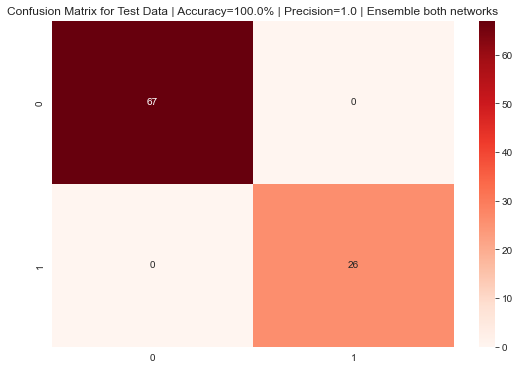

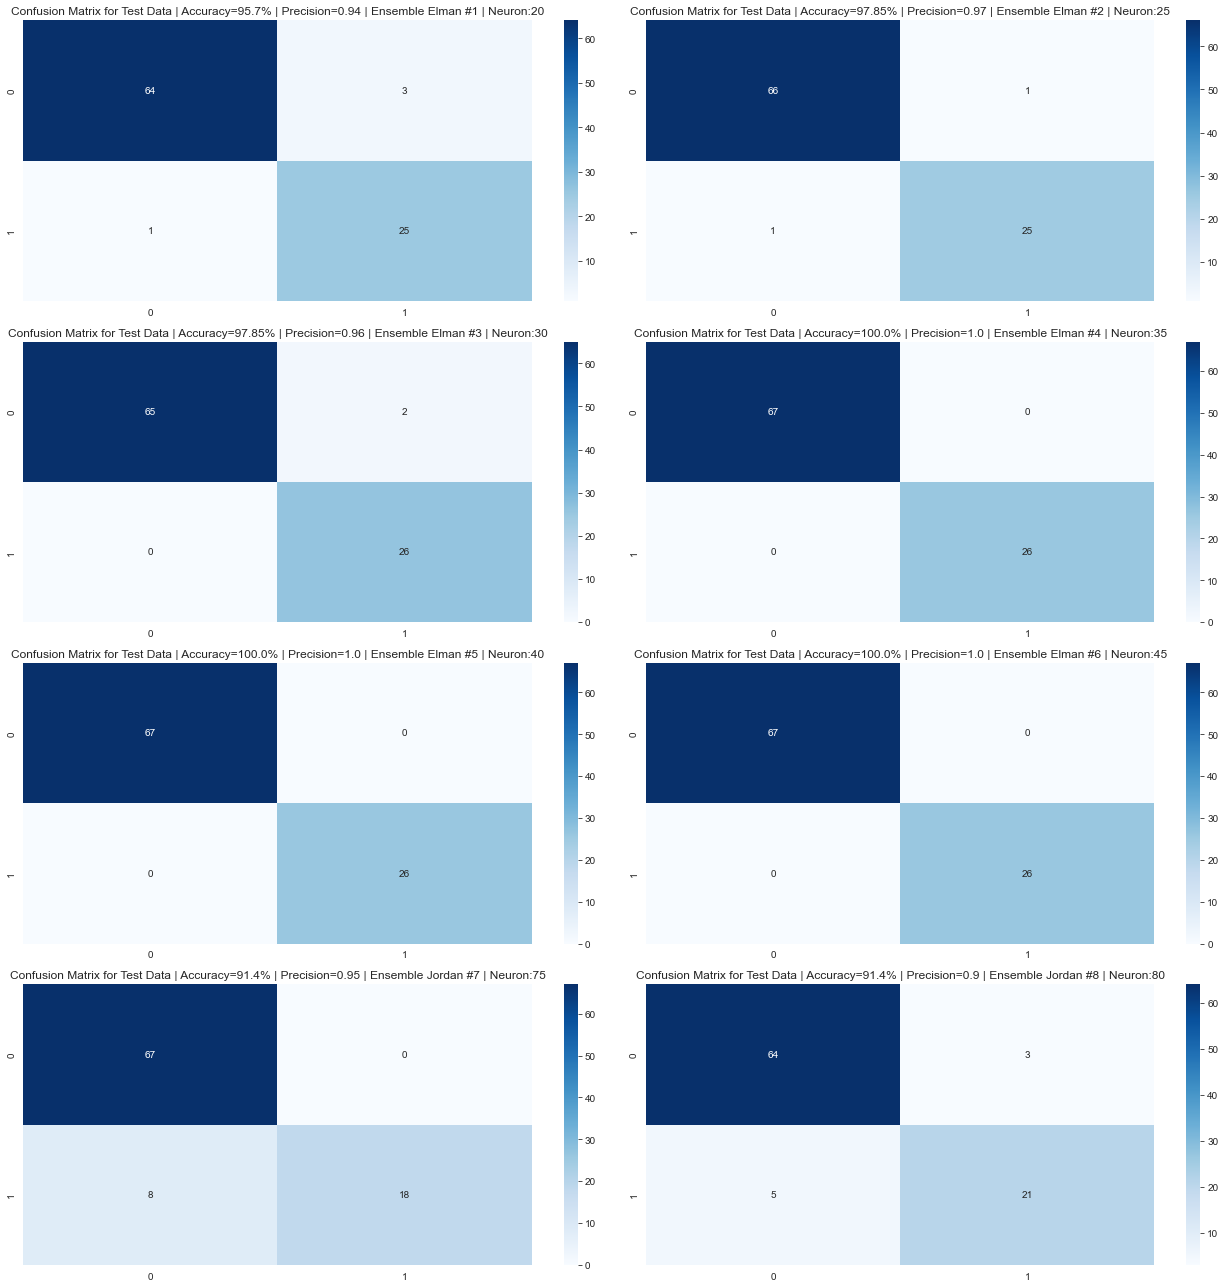

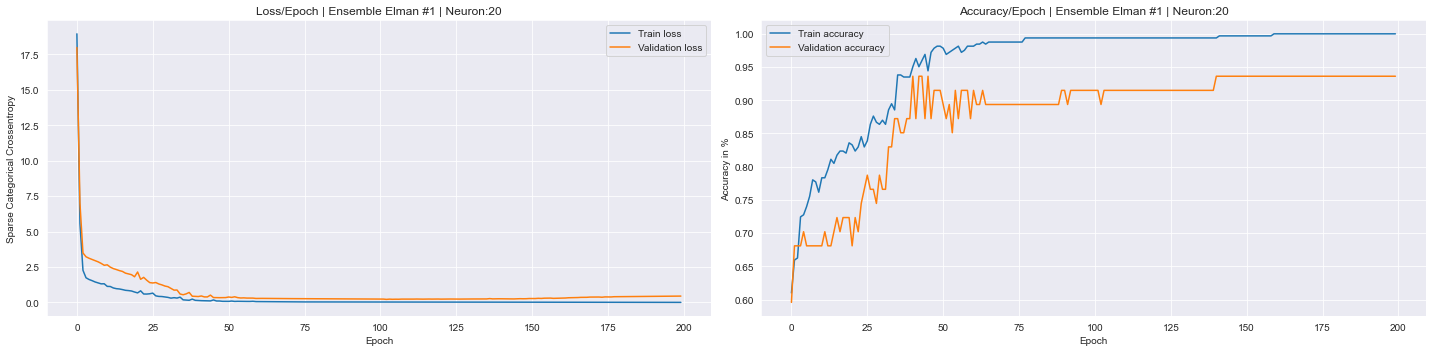

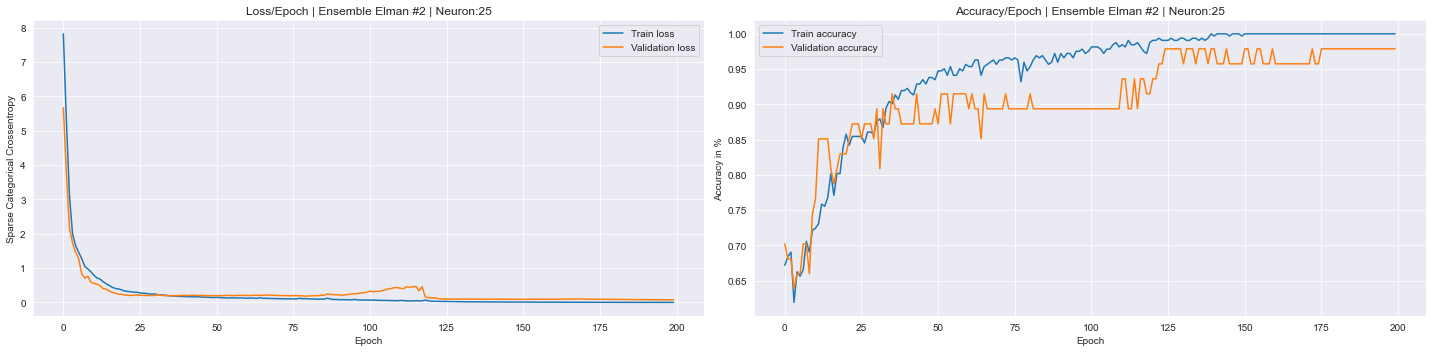

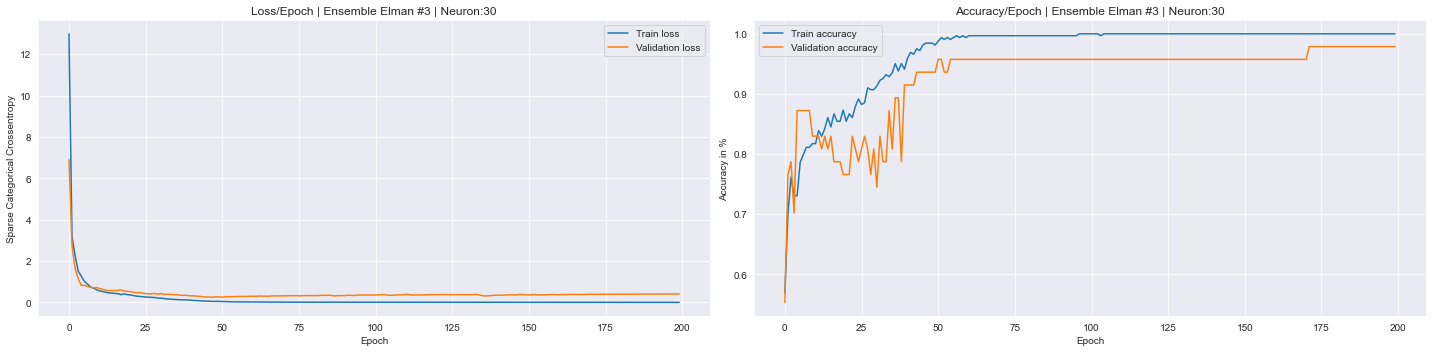

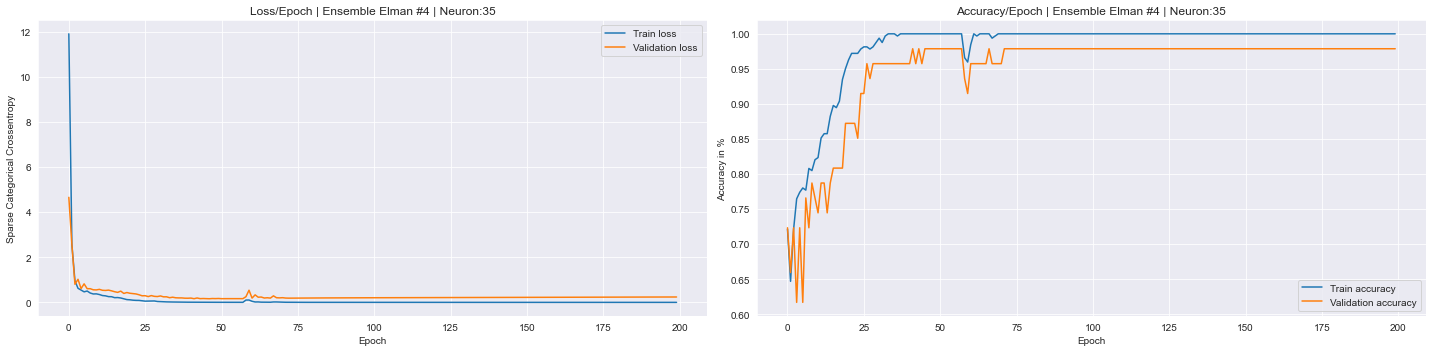

<Figure size 1440x360 with 0 Axes>

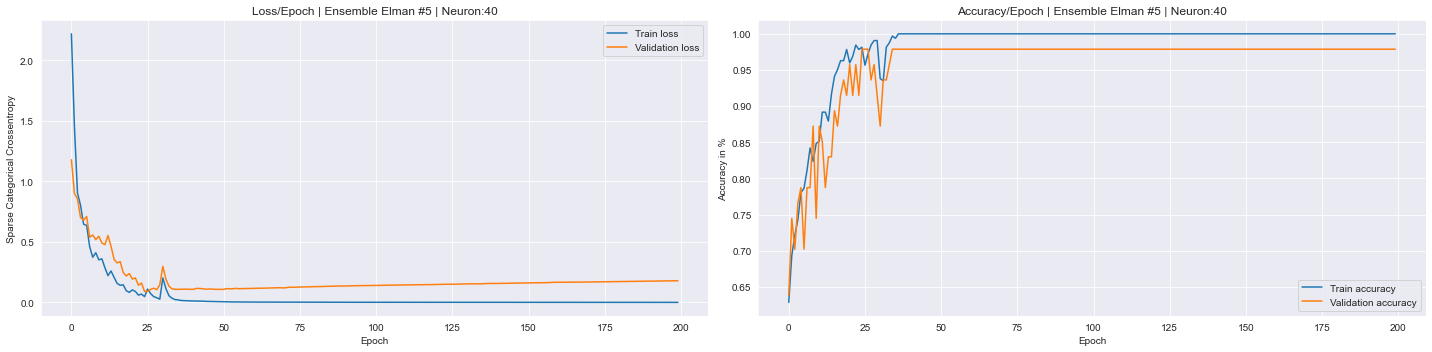

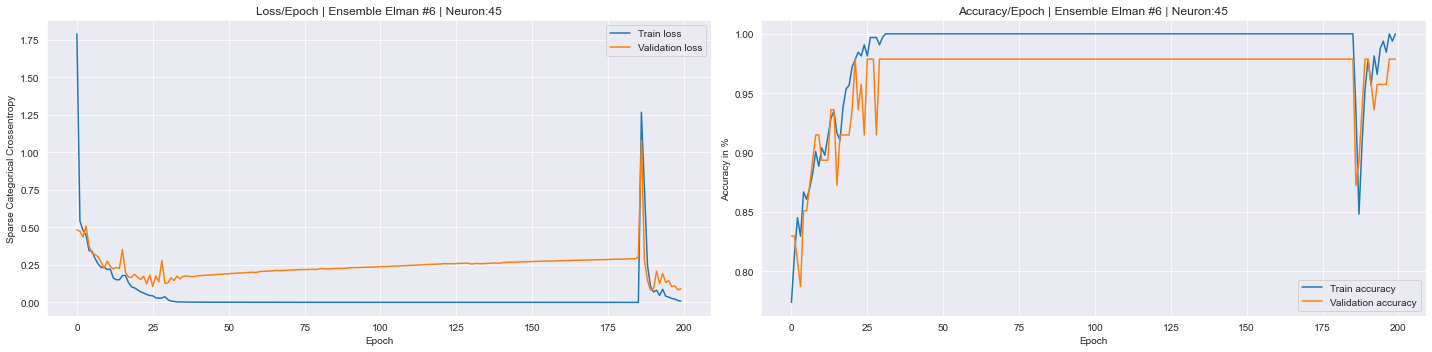

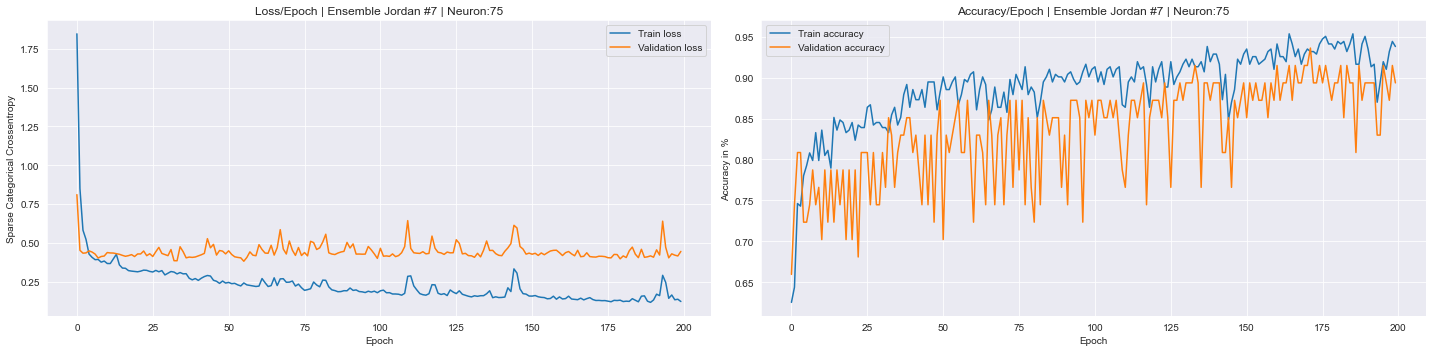

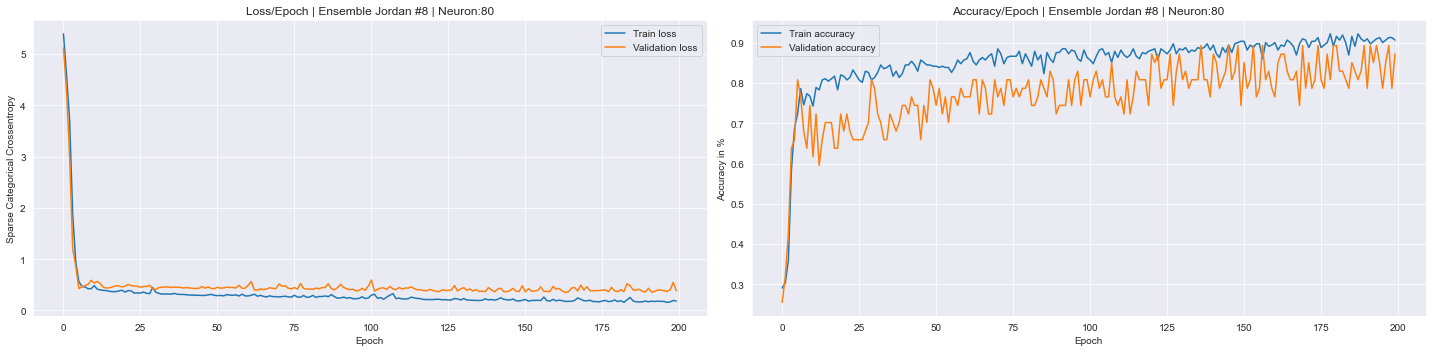

<Figure size 1440x360 with 0 Axes>

In [7]:
_input = Input(shape=(15,6))
out_models = [] 
for model in models :
    out_models.append(model(_input))

_avg = Average()(out_models)
out = keras.activations.softmax(_avg)

MODEL_1 = keras.Model(inputs=_input,outputs=out)
keras.utils.plot_model(MODEL_1,expand_nested=True,show_layer_activations=True,
                       show_shapes=True,show_layer_names=False,to_file="Ensemble both networks.png")


CalculateMetricsAndPlot(Y_test,np.argmax(MODEL_1.predict(X_test),axis=1),Colors[1],"Ensemble both networks")


plt.rcParams['figure.figsize'] = [18, 18]
for i in range(1,9):
    if i ==7 or i ==8 :
        net = "Jordan"
    else:
        net = "Elman"
    plt.subplot(4,2,i)
    CalculateMetricsAndPlot(Y_test,np.argmax(models[i-1].predict(X_test),axis=1),
                            "Blues","Ensemble {2} #{0} | Neuron:{1}".format(i,N[i-1],net),is_show=False)

plt.tight_layout()
plt.show()

plt.rcParams['figure.figsize'] = [20, 5]
for i in range(1,5):
    plt.subplot(4,1,i)
    TrainingPlot(histories[i-1],"Ensemble Elman #{0} | Neuron:{1}".format(i,N[i-1]).format(i),is_show=False)

plt.tight_layout()
plt.show()

for i in range(5,9):
    if i ==7 or i ==8 :
        net = "Jordan"
    else:
        net = "Elman"
        
    plt.subplot(4,1,i-4)
    TrainingPlot(histories[i-1],"Ensemble {2} #{0} | Neuron:{1}".format(i,N[i-1],net),is_show=False)
plt.tight_layout()
plt.show()